In [1]:
from image_io import czi2zarr, get_mosaic_dask
import os
import numpy as np
import dask.array as da
from aicsimageio import AICSImage
import dask_image as da_image
from dask import delayed
from dask.diagnostics import ProgressBar
import zarr
from skimage.io import imshow
from matplotlib import pyplot as plt
from tifffile import imwrite


In [2]:
def tiff2Zarr(fpath,
              outpath,
              block_size_max=1e8):

    if not os.path.exists(outpath):
        os.mkdir(outpath)

    im = AICSImage(fpath).dask_data
    im = im.rechunk(block_size_limit=block_size_max)
    im = im[0, 0, :, :, :]
    with ProgressBar(dt=0.5):
        da.to_zarr(im, outpath, overwrite=True)

    im = da.from_zarr(outpath)
    return im

In [3]:
seg_file = "/vast/scratch/users/whitehead/sabrina/935_all_met_mask_median3filter-lbl.tif"
c1_file = "/vast/scratch/users/whitehead/sabrina/MASK_C1_935_threshold230.tif"
c2_file = "/vast/scratch/users/whitehead/sabrina/MASK_C2_935_threshold220.tif"
c3_file = "/vast/scratch/users/whitehead/sabrina/MASK_C3_935_threshold61.tif"
csv_file = "/stornext/General/scratch/GP_Transfer/Lachie/935_all_met_mask_median3filter-lbl-morpho.csv"
raw_file = "/vast/scratch/users/whitehead/sabrina/211012_ms935_MDA_lung1_tilescan-Dual Side Fusion-01_stitching.czi"

dir1 = "/vast/scratch/users/whitehead/sabrina/"

csv_file = "Y:/Lachie/935_all_met_mask_median3filter-lbl-morpho.csv"

In [4]:
all_mets = []
voxel_volume = 38.7 #(um**3)

with open(csv_file,'r') as f:
    print(f.readline())
    for l in f:
        line = str.split(l,',')
        line = [int(l) for l in line]
        all_mets.append(line)
        
for l in all_mets:
    l[1]  = l[1] * 38.7
           

Label,Volume,Box.X.Min,Box.X.Max,Box.Y.Min,Box.Y.Max,Box.Z.Min,Box.Z.Max



In [9]:
print(len([x for x in all_mets if x[1]>10]))

23187


In [5]:
%%time
raw_zarr_path = os.path.join(dir1,"raw_zarr")
if not os.path.exists(raw_zarr_path):
    os.mkdir(raw_zarr_path)
    
if os.path.exists(os.path.join(raw_zarr_path,".zarray")):
    raw_zarr = da.from_zarr(raw_zarr_path)
else:
    raw_zarr = czi2zarr(raw_file,raw_zarr_path)
    


CPU times: user 1.28 ms, sys: 1.47 ms, total: 2.75 ms
Wall time: 8.27 ms


### This sometimes kills the kernel? 

In [6]:
%%time 
c1_zarr_path = os.path.join(dir1,"c1_zarr")
if not os.path.exists(os.path.join(c1_zarr_path,'.zarray')):
    c1_zarr = tiff2Zarr(c1_file,c1_zarr_path)
else:
    c1_zarr = da.from_zarr(c1_zarr_path)    
    
c2_zarr_path = os.path.join(dir1,"c2_zarr")
if not os.path.exists(os.path.join(c2_zarr_path,'.zarray')):
    c2_zarr = tiff2Zarr(c2_file,c2_zarr_path)
else:
    c2_zarr = da.from_zarr(c2_zarr_path)

c3_zarr_path = os.path.join(dir1,"c3_zarr")
if not os.path.exists(os.path.join(c3_zarr_path,'.zarray')):
    c3_zarr = tiff2Zarr(c3_file,c3_zarr_path)
else:
    c3_zarr = da.from_zarr(c3_zarr_path)

CPU times: user 2.7 ms, sys: 940 µs, total: 3.64 ms
Wall time: 11.9 ms


In [7]:
%%time
seg_zarr_path = os.path.join(dir1,"seg_zarr")
seg_zarr = tiff2Zarr(seg_file,seg_zarr_path)
seg_zarr = da.from_zarr(seg_zarr_path)


[########################################] | 100% Completed | 89.96 s
CPU times: user 57.3 s, sys: 1min 27s, total: 2min 25s
Wall time: 1min 30s


In [8]:
def make_binary(im,binary_value):
    binVal = 2 ** binary_value
    x = binVal * (im / 255)
    return x
    

In [138]:
met_num = 47

this_met = [x for x in all_mets if x[0]==met_num][0]
print(this_met)

x1,x2,y1,y2,z1,z2 = this_met[2:]

[47, 729840204.0, 353, 1218, 1911, 3210, 0, 443]


In [79]:
%%time
roi = raw_zarr[0,:,z1:z2,3*y1:3*y2,3*x1:3*x2]
roi = roi.swapaxes(0,1)

c1_roi = c1_zarr[z1:z2,y1:y2,x1:x2]
c2_roi = c2_zarr[z1:z2,y1:y2,x1:x2]
c3_roi = c3_zarr[z1:z2,y1:y2,x1:x2]
seg_roi = seg_zarr[z1:z2,y1:y2,x1:x2]==met_num

CPU times: user 2.47 ms, sys: 504 µs, total: 2.98 ms
Wall time: 2.98 ms


In [80]:
seg_roi.shape

(42, 35, 41)

In [81]:
c1_masked = c1_roi * seg_roi
c2_masked = c2_roi * seg_roi
c3_masked = c3_roi * seg_roi

In [82]:
c1_bin = make_binary(c1_masked,0)
c2_bin = make_binary(c2_masked,1)
c3_bin = make_binary(c3_masked,2)

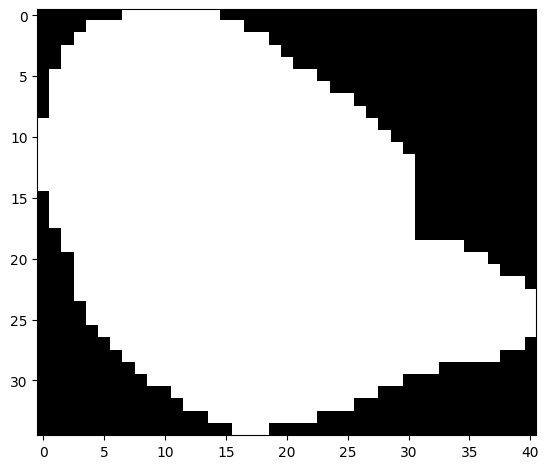

In [83]:
imshow(np.max(seg_roi,axis=0))

/home/users/allstaff/whitehead/.conda/envs/bac2/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


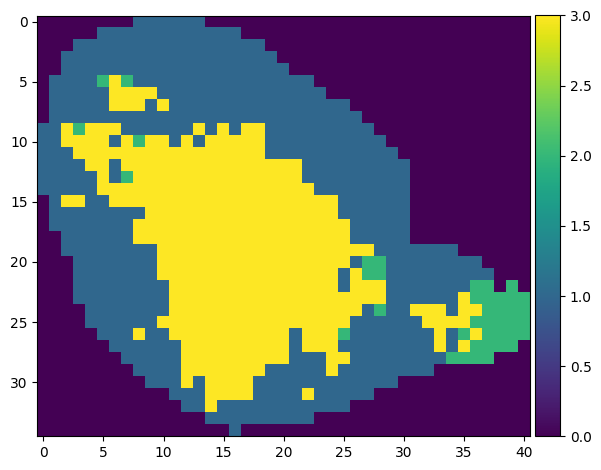

In [84]:
masked_sum = c1_bin + c2_bin + c3_bin
z_size,y_size,x_size = masked_sum.shape

imshow(np.max(masked_sum,axis=0))


In [85]:
output_im = da.zeros((7,z_size,y_size,x_size),dtype=np.uint8)
for c in range(1,8):
    ch = 255 * (masked_sum==c)
    output_im[c-1,:,:,:] = ch
    

In [86]:
output_im = output_im.swapaxes(0,1)
output_im.shape



(42, 7, 35, 41)

In [87]:
%%time
output_im = output_im.compute()

CPU times: user 241 ms, sys: 498 ms, total: 739 ms
Wall time: 176 ms


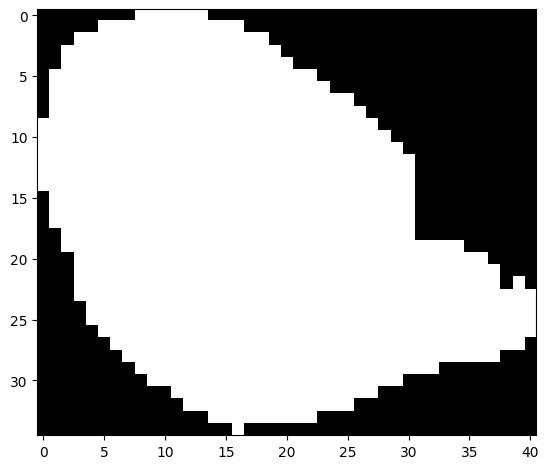

In [88]:
x = np.max(output_im,axis=0)
imshow(np.max(x,axis=0))

In [89]:
xy_pixels = 1.2197*3
z_pixels = 2.8846

In [90]:
%%time
a = imwrite('test.tif',
            output_im,
            resolution = (1./xy_pixels,1./xy_pixels),
            metadata = {'spacing':z_pixels,
                        'unit':'um',
                        'axes':'ZCYX'},
                        imagej=True
           )


CPU times: user 2.33 ms, sys: 10.4 ms, total: 12.7 ms
Wall time: 10.2 ms


In [91]:
scores = []
lego = masked_sum.compute()
for i in range(1,8):
    score = np.sum(lego==i)
    scores.append(score)

print(scores)

[13087, 164, 3059, 0, 0, 0, 0]


In [92]:
ratio_scores = [x / np.sum(scores) for x in scores]
for i in range(1,8):
    print(format(i,"03b"),ratio_scores[i-1])


001 0.8023911710606989
010 0.010055180870631515
011 0.18755364806866953
100 0.0
101 0.0
110 0.0
111 0.0


In [93]:
output = [['MET_ID','Volume','001','010','011','100','101','110','111']]
res = [met_num,this_met[1]]

for s in ratio_scores:
    res.append(s)



output.append(res)

print(res)

print(output)


[2, 651475.8, 0.8023911710606989, 0.010055180870631515, 0.18755364806866953, 0.0, 0.0, 0.0, 0.0]
[['MET_ID', 'Volume', '001', '010', '011', '100', '101', '110', '111'], [2, 651475.8, 0.8023911710606989, 0.010055180870631515, 0.18755364806866953, 0.0, 0.0, 0.0, 0.0]]


In [66]:
for l in output:
    print('%s,%s,%s,%s,%s,%s,%s,%s,%s' % (l[0],
                     l[1],
                     l[2],
                     l[3],
                     l[4],
                     l[5],
                     l[6],
                     l[7],
                     l[8]))
                     

MET_ID,Volume,001,010,011,100,101,110,111
7883,164544969.60000002,0.2747175338787863,0.1644621608138352,0.5591648279906528,0.0002286436493861526,0.00023837316638130804,0.0003021015026995761,0.0008863589982586597


In [67]:
with open('test.csv','w') as f:
    for l in output:
        print('%s,%s,%s,%s,%s,%s,%s,%s,%s' % (l[0],
                     l[1],
                     l[2],
                     l[3],
                     l[4],
                     l[5],
                     l[6],
                     l[7],
                     l[8]),file=f)
        

In [141]:
output_dir = os.path.join(dir1,'output_mets')

xy_pixels = 1.2197*3
z_pixels = 2.8846

output = [['MET_ID','Volume','001','010','011','100','101','110','111']]

save_tiff = False
save_full_res = True

for met in all_mets:
    if met[1] > 1000:
        
        met_num = met[0]
        met_vol = met[1]
        print("DOING MET_ID: %i" % met_num)
        
        #get coords:
        x1,x2,y1,y2,z1,z2 = met[2:]
        if z2 - z1 >= 3:
        
            #raw data - deal with this later
            if save_full_res:
                if met_num != 47: #47 is too damn large
                    roi = raw_zarr[0,:,z1:z2,3*y1:3*y2,3*x1:3*x2]
                    roi = roi.swapaxes(0,1)
                    out_file = os.path.join(dir1,'Met_%i.tif' % met_num)
                    a = imwrite(out_file,
                                roi[:,0:4,:,:],
                                resolution=(1./xy_pixels,1./xy_pixels),           
                                metadata={'spacing': z_pixels, 'unit': 'um', 'axes': 'ZCYX'},
                                imagej=True)

            # get rois
            c1_roi = c1_zarr[z1:z2,y1:y2,x1:x2]
            c2_roi = c2_zarr[z1:z2,y1:y2,x1:x2]
            c3_roi = c3_zarr[z1:z2,y1:y2,x1:x2]
            seg_roi = seg_zarr[z1:z2,y1:y2,x1:x2]==met_num

            # mask and get lego
            c1_masked = c1_roi * seg_roi
            c2_masked = c2_roi * seg_roi
            c3_masked = c3_roi * seg_roi

            c1_bin = make_binary(c1_masked,0)
            c2_bin = make_binary(c2_masked,1)
            c3_bin = make_binary(c3_masked,2)

            masked_sum = c1_bin + c2_bin + c3_bin
            z_size,y_size,x_size = masked_sum.shape

            lego = masked_sum.compute()

            #calculate scores and store results
            scores = []
            for i in range(1,8):
                score = np.sum(lego==i)
                scores.append(score)

            print(np.sum(scores))
            ratio_scores = [x / np.sum(scores) for x in scores]

            res = [met_num,met[1]]
            for s in ratio_scores:
                res.append(s)
            output.append(res)

            #save TIF mask
            if save_tiff:
                output_im = da.zeros((7,z_size,y_size,x_size),dtype=np.uint8)
                for c in range(1,8):
                    ch = 255 * (lego==c)
                    output_im[c-1,:,:,:] = ch

                a = imwrite(os.path.join(output_dir,'met_%i_mask.tif' % met_num),
                            output_im,
                            resolution = (1./xy_pixels,1./xy_pixels),
                            metadata = {'spacing':z_pixels,
                                        'unit':'um',
                                        'axes':'ZCYX'},
                                        imagej=True
                           )

print("DONE")

DOING MET_ID: 2
16310
DOING MET_ID: 4
DOING MET_ID: 5
52735
DOING MET_ID: 9
4908
DOING MET_ID: 10
78193
DOING MET_ID: 11
1524
DOING MET_ID: 12
85
DOING MET_ID: 15
24014
DOING MET_ID: 16
DOING MET_ID: 19
61331
DOING MET_ID: 22
6396
DOING MET_ID: 23
DOING MET_ID: 26
297275
DOING MET_ID: 27
22442
DOING MET_ID: 28
3278
DOING MET_ID: 29
DOING MET_ID: 30
10798
DOING MET_ID: 31
2229
DOING MET_ID: 32
DOING MET_ID: 33
1424
DOING MET_ID: 35
DOING MET_ID: 37
DOING MET_ID: 38
DOING MET_ID: 40
DOING MET_ID: 44
442061
DOING MET_ID: 45
DOING MET_ID: 46
846
DOING MET_ID: 47
18073792
DOING MET_ID: 48
782
DOING MET_ID: 50
DOING MET_ID: 51
DOING MET_ID: 52
34
DOING MET_ID: 53
369969
DOING MET_ID: 55
DOING MET_ID: 56
180
DOING MET_ID: 59
838
DOING MET_ID: 60
58
DOING MET_ID: 61
71
DOING MET_ID: 62
DOING MET_ID: 63
390
DOING MET_ID: 64
DOING MET_ID: 65
102300
DOING MET_ID: 69
629
DOING MET_ID: 72
435
DOING MET_ID: 73
DOING MET_ID: 74
18539
DOING MET_ID: 77
14941
DOING MET_ID: 78
1619
DOING MET_ID: 79
79
DO

49
DOING MET_ID: 850
1772
DOING MET_ID: 853
6478
DOING MET_ID: 855
163
DOING MET_ID: 859
68
DOING MET_ID: 860
DOING MET_ID: 864
23
DOING MET_ID: 866
69
DOING MET_ID: 873
135
DOING MET_ID: 877
92
DOING MET_ID: 878
130
DOING MET_ID: 879
48
DOING MET_ID: 887
DOING MET_ID: 889
118292
DOING MET_ID: 891
14280
DOING MET_ID: 897
42724
DOING MET_ID: 898
DOING MET_ID: 900
22
DOING MET_ID: 903
33
DOING MET_ID: 904
215
DOING MET_ID: 908
149
DOING MET_ID: 911
148
DOING MET_ID: 912
1269
DOING MET_ID: 913
DOING MET_ID: 916
2063
DOING MET_ID: 917
1038
DOING MET_ID: 918
38
DOING MET_ID: 919
40201
DOING MET_ID: 922
2770
DOING MET_ID: 923
196
DOING MET_ID: 926
1064
DOING MET_ID: 927
13928
DOING MET_ID: 928
DOING MET_ID: 929
74
DOING MET_ID: 932
DOING MET_ID: 933
109
DOING MET_ID: 938
27
DOING MET_ID: 939
7789
DOING MET_ID: 945
576
DOING MET_ID: 947
49
DOING MET_ID: 952
43
DOING MET_ID: 953
254908
DOING MET_ID: 955
46
DOING MET_ID: 956
26070
DOING MET_ID: 961
576
DOING MET_ID: 963
87
DOING MET_ID: 965
21


25
DOING MET_ID: 1815
32
DOING MET_ID: 1826
DOING MET_ID: 1827
368
DOING MET_ID: 1834
48
DOING MET_ID: 1836
362
DOING MET_ID: 1840
DOING MET_ID: 1841
329
DOING MET_ID: 1846
43485
DOING MET_ID: 1852
28
DOING MET_ID: 1853
57
DOING MET_ID: 1855
105652
DOING MET_ID: 1857
DOING MET_ID: 1860
108
DOING MET_ID: 1861
44
DOING MET_ID: 1863
62
DOING MET_ID: 1865
31
DOING MET_ID: 1867
42
DOING MET_ID: 1870
429
DOING MET_ID: 1871
114
DOING MET_ID: 1875
174
DOING MET_ID: 1876
42
DOING MET_ID: 1877
DOING MET_ID: 1878
27
DOING MET_ID: 1879
37684
DOING MET_ID: 1882
337
DOING MET_ID: 1885
16510
DOING MET_ID: 1887
43
DOING MET_ID: 1891
57231
DOING MET_ID: 1893
133
DOING MET_ID: 1894
35
DOING MET_ID: 1895
79
DOING MET_ID: 1896
65
DOING MET_ID: 1900
20795
DOING MET_ID: 1902
175
DOING MET_ID: 1905
DOING MET_ID: 1906
127
DOING MET_ID: 1912
146
DOING MET_ID: 1914
610
DOING MET_ID: 1916
15933
DOING MET_ID: 1917
8459
DOING MET_ID: 1919
80
DOING MET_ID: 1922
40
DOING MET_ID: 1923
23
DOING MET_ID: 1924
99890
DOIN

91
DOING MET_ID: 2665
23
DOING MET_ID: 2666
348
DOING MET_ID: 2671
78
DOING MET_ID: 2673
27
DOING MET_ID: 2674
140
DOING MET_ID: 2676
36
DOING MET_ID: 2677
45
DOING MET_ID: 2678
DOING MET_ID: 2679
150
DOING MET_ID: 2681
142
DOING MET_ID: 2682
62
DOING MET_ID: 2685
60
DOING MET_ID: 2686
DOING MET_ID: 2690
48
DOING MET_ID: 2691
DOING MET_ID: 2692
2202
DOING MET_ID: 2694
9409
DOING MET_ID: 2695
584
DOING MET_ID: 2701
136
DOING MET_ID: 2702
DOING MET_ID: 2706
DOING MET_ID: 2707
84
DOING MET_ID: 2710
385
DOING MET_ID: 2714
1489
DOING MET_ID: 2716
87
DOING MET_ID: 2722
DOING MET_ID: 2729
4969
DOING MET_ID: 2730
70
DOING MET_ID: 2732
194
DOING MET_ID: 2733
DOING MET_ID: 2739
139019
DOING MET_ID: 2742
435
DOING MET_ID: 2746
DOING MET_ID: 2749
35
DOING MET_ID: 2750
61
DOING MET_ID: 2753
103
DOING MET_ID: 2756
149
DOING MET_ID: 2757
55
DOING MET_ID: 2760
319
DOING MET_ID: 2762
2134
DOING MET_ID: 2765
165
DOING MET_ID: 2771
87
DOING MET_ID: 2772
87
DOING MET_ID: 2774
DOING MET_ID: 2776
253
DOING 

127
DOING MET_ID: 3602
2449
DOING MET_ID: 3608
80674
DOING MET_ID: 3610
30
DOING MET_ID: 3614
200
DOING MET_ID: 3616
78
DOING MET_ID: 3617
141
DOING MET_ID: 3618
122
DOING MET_ID: 3619
158
DOING MET_ID: 3620
60
DOING MET_ID: 3625
466
DOING MET_ID: 3626
94
DOING MET_ID: 3627
41
DOING MET_ID: 3628
9410
DOING MET_ID: 3630
DOING MET_ID: 3634
3345118
DOING MET_ID: 3635
20
DOING MET_ID: 3636
104
DOING MET_ID: 3640
DOING MET_ID: 3645
434
DOING MET_ID: 3647
47
DOING MET_ID: 3648
86204
DOING MET_ID: 3649
1552
DOING MET_ID: 3650
709
DOING MET_ID: 3651
5526
DOING MET_ID: 3652
34
DOING MET_ID: 3660
101
DOING MET_ID: 3661
1758
DOING MET_ID: 3668
147
DOING MET_ID: 3669
12256
DOING MET_ID: 3672
30666
DOING MET_ID: 3675
17019
DOING MET_ID: 3676
25915
DOING MET_ID: 3677
24
DOING MET_ID: 3683
410505
DOING MET_ID: 3685
6800
DOING MET_ID: 3686
252
DOING MET_ID: 3687
15705
DOING MET_ID: 3690
46
DOING MET_ID: 3691
57
DOING MET_ID: 3694
41
DOING MET_ID: 3696
917
DOING MET_ID: 3697
186
DOING MET_ID: 3702
176


100
DOING MET_ID: 4455
2500
DOING MET_ID: 4456
43
DOING MET_ID: 4461
38
DOING MET_ID: 4463
336
DOING MET_ID: 4464
994
DOING MET_ID: 4465
31
DOING MET_ID: 4466
106512
DOING MET_ID: 4467
755
DOING MET_ID: 4472
145
DOING MET_ID: 4474
61
DOING MET_ID: 4475
839
DOING MET_ID: 4478
858
DOING MET_ID: 4479
DOING MET_ID: 4480
161
DOING MET_ID: 4486
48
DOING MET_ID: 4487
DOING MET_ID: 4489
52
DOING MET_ID: 4490
35
DOING MET_ID: 4495
73
DOING MET_ID: 4496
90
DOING MET_ID: 4498
819
DOING MET_ID: 4500
64
DOING MET_ID: 4503
97
DOING MET_ID: 4505
24
DOING MET_ID: 4506
31
DOING MET_ID: 4507
25
DOING MET_ID: 4510
24
DOING MET_ID: 4511
111
DOING MET_ID: 4512
188
DOING MET_ID: 4515
DOING MET_ID: 4517
342
DOING MET_ID: 4519
162
DOING MET_ID: 4523
339
DOING MET_ID: 4524
178
DOING MET_ID: 4527
1830
DOING MET_ID: 4528
27584
DOING MET_ID: 4530
573
DOING MET_ID: 4534
20463
DOING MET_ID: 4535
DOING MET_ID: 4536
373
DOING MET_ID: 4540
599
DOING MET_ID: 4541
70
DOING MET_ID: 4542
98
DOING MET_ID: 4550
1694
DOING M

58
DOING MET_ID: 5272
348
DOING MET_ID: 5273
87360
DOING MET_ID: 5275
159
DOING MET_ID: 5276
35
DOING MET_ID: 5278
48
DOING MET_ID: 5280
483
DOING MET_ID: 5282
2839
DOING MET_ID: 5283
79
DOING MET_ID: 5288
DOING MET_ID: 5290
118
DOING MET_ID: 5293
31
DOING MET_ID: 5294
DOING MET_ID: 5297
321
DOING MET_ID: 5300
50
DOING MET_ID: 5301
86
DOING MET_ID: 5303
347069
DOING MET_ID: 5304
312
DOING MET_ID: 5305
574
DOING MET_ID: 5309
DOING MET_ID: 5311
2100
DOING MET_ID: 5312
13270
DOING MET_ID: 5315
DOING MET_ID: 5318
38
DOING MET_ID: 5324
44
DOING MET_ID: 5325
267
DOING MET_ID: 5330
34
DOING MET_ID: 5332
45
DOING MET_ID: 5333
32
DOING MET_ID: 5335
1758
DOING MET_ID: 5341
3292
DOING MET_ID: 5342
37
DOING MET_ID: 5344
128
DOING MET_ID: 5347
108
DOING MET_ID: 5349
36
DOING MET_ID: 5350
87
DOING MET_ID: 5352
47
DOING MET_ID: 5353
76
DOING MET_ID: 5357
4160
DOING MET_ID: 5358
6993
DOING MET_ID: 5360
18396
DOING MET_ID: 5362
123
DOING MET_ID: 5363
DOING MET_ID: 5367
23
DOING MET_ID: 5368
181
DOING M

99
DOING MET_ID: 6073
111
DOING MET_ID: 6074
46
DOING MET_ID: 6075
78
DOING MET_ID: 6076
52
DOING MET_ID: 6080
3481
DOING MET_ID: 6081
2525
DOING MET_ID: 6082
111
DOING MET_ID: 6084
34
DOING MET_ID: 6086
53
DOING MET_ID: 6087
28
DOING MET_ID: 6089
53
DOING MET_ID: 6092
73
DOING MET_ID: 6094
12678
DOING MET_ID: 6095
537
DOING MET_ID: 6097
25
DOING MET_ID: 6098
502
DOING MET_ID: 6100
62
DOING MET_ID: 6103
186
DOING MET_ID: 6104
144
DOING MET_ID: 6105
984
DOING MET_ID: 6108
111
DOING MET_ID: 6112
47
DOING MET_ID: 6113
152612
DOING MET_ID: 6114
423
DOING MET_ID: 6115
DOING MET_ID: 6116
436
DOING MET_ID: 6118
122997
DOING MET_ID: 6119
35
DOING MET_ID: 6120
6331
DOING MET_ID: 6131
775
DOING MET_ID: 6132
81
DOING MET_ID: 6133
27
DOING MET_ID: 6135
DOING MET_ID: 6136
43
DOING MET_ID: 6137
12842
DOING MET_ID: 6139
77171
DOING MET_ID: 6141
429
DOING MET_ID: 6143
241
DOING MET_ID: 6144
117
DOING MET_ID: 6145
98
DOING MET_ID: 6147
136
DOING MET_ID: 6148
265
DOING MET_ID: 6151
22
DOING MET_ID: 6155

201
DOING MET_ID: 6862
54
DOING MET_ID: 6863
70
DOING MET_ID: 6867
40
DOING MET_ID: 6868
80
DOING MET_ID: 6869
1262
DOING MET_ID: 6870
160
DOING MET_ID: 6874
52
DOING MET_ID: 6878
DOING MET_ID: 6879
162955
DOING MET_ID: 6881
46
DOING MET_ID: 6882
388
DOING MET_ID: 6884
190
DOING MET_ID: 6885
179
DOING MET_ID: 6887
129
DOING MET_ID: 6888
30
DOING MET_ID: 6890
256
DOING MET_ID: 6891
6458
DOING MET_ID: 6892
12147
DOING MET_ID: 6894
DOING MET_ID: 6896
22
DOING MET_ID: 6899
8651
DOING MET_ID: 6900
205
DOING MET_ID: 6901
9868
DOING MET_ID: 6902
123791
DOING MET_ID: 6904
110959
DOING MET_ID: 6905
45
DOING MET_ID: 6906
93
DOING MET_ID: 6908
42
DOING MET_ID: 6909
265
DOING MET_ID: 6910
7747
DOING MET_ID: 6916
243312
DOING MET_ID: 6917
23
DOING MET_ID: 6919
152
DOING MET_ID: 6920
139
DOING MET_ID: 6921
81
DOING MET_ID: 6923
1389
DOING MET_ID: 6925
182
DOING MET_ID: 6926
133
DOING MET_ID: 6927
6318
DOING MET_ID: 6929
83
DOING MET_ID: 6931
175
DOING MET_ID: 6935
376
DOING MET_ID: 6936
255
DOING ME

125
DOING MET_ID: 7610
130
DOING MET_ID: 7615
60
DOING MET_ID: 7617
70
DOING MET_ID: 7618
160
DOING MET_ID: 7619
119
DOING MET_ID: 7621
30
DOING MET_ID: 7622
97
DOING MET_ID: 7623
39188
DOING MET_ID: 7625
19002
DOING MET_ID: 7626
91
DOING MET_ID: 7628
574
DOING MET_ID: 7630
18217
DOING MET_ID: 7631
42
DOING MET_ID: 7632
45
DOING MET_ID: 7634
878
DOING MET_ID: 7635
13972
DOING MET_ID: 7637
362
DOING MET_ID: 7642
129818
DOING MET_ID: 7644
39
DOING MET_ID: 7645
40
DOING MET_ID: 7647
51
DOING MET_ID: 7648
96
DOING MET_ID: 7649
49
DOING MET_ID: 7652
47
DOING MET_ID: 7653
67
DOING MET_ID: 7655
29
DOING MET_ID: 7658
38
DOING MET_ID: 7663
92
DOING MET_ID: 7665
24608
DOING MET_ID: 7667
52
DOING MET_ID: 7670
127
DOING MET_ID: 7671
62
DOING MET_ID: 7674
97
DOING MET_ID: 7678
137
DOING MET_ID: 7682
77
DOING MET_ID: 7684
191
DOING MET_ID: 7687
63
DOING MET_ID: 7688
DOING MET_ID: 7692
339
DOING MET_ID: 7694
111
DOING MET_ID: 7696
172
DOING MET_ID: 7702
9390
DOING MET_ID: 7704
853
DOING MET_ID: 7705


/home/users/allstaff/whitehead/.conda/envs/bac2/lib/python3.9/site-packages/tifffile/tifffile.py:3375: UserWarning: <tifffile.TiffWriter 'Met_7883.tif'> truncating ImageJ file
  warnings.warn(


4111201
DOING MET_ID: 7884
DOING MET_ID: 7885
540
DOING MET_ID: 7888
88
DOING MET_ID: 7889
558
DOING MET_ID: 7890
178
DOING MET_ID: 7892
50
DOING MET_ID: 7893
186
DOING MET_ID: 7894
35
DOING MET_ID: 7897
39
DOING MET_ID: 7899
10656
DOING MET_ID: 7902
262894
DOING MET_ID: 7904
50851
DOING MET_ID: 7907
40
DOING MET_ID: 7908
DOING MET_ID: 7909
33
DOING MET_ID: 7912
1284
DOING MET_ID: 7913
51
DOING MET_ID: 7916
DOING MET_ID: 7922
137
DOING MET_ID: 7925
DOING MET_ID: 7926
120
DOING MET_ID: 7928
203527
DOING MET_ID: 7929
8880
DOING MET_ID: 7931
90
DOING MET_ID: 7936
34
DOING MET_ID: 7939
92
DOING MET_ID: 7943
987
DOING MET_ID: 7951
DOING MET_ID: 7952
29
DOING MET_ID: 7953
167
DOING MET_ID: 7954
102
DOING MET_ID: 7959
258
DOING MET_ID: 7960
136
DOING MET_ID: 7964
44
DOING MET_ID: 7965
119
DOING MET_ID: 7966
903
DOING MET_ID: 7970
55
DOING MET_ID: 7973
128
DOING MET_ID: 7977
69
DOING MET_ID: 7979
31
DOING MET_ID: 7980
22
DOING MET_ID: 7982
516
DOING MET_ID: 7984
61
DOING MET_ID: 7986
113
DOING

92
DOING MET_ID: 8761
DOING MET_ID: 8762
DOING MET_ID: 8770
DOING MET_ID: 8771
238
DOING MET_ID: 8773
DOING MET_ID: 8778
DOING MET_ID: 8783
DOING MET_ID: 8788
206
DOING MET_ID: 8796
DOING MET_ID: 8802
DOING MET_ID: 8805
DOING MET_ID: 8806
DOING MET_ID: 8816
DOING MET_ID: 8820
DOING MET_ID: 8831
48
DOING MET_ID: 8834
DOING MET_ID: 8835
DOING MET_ID: 8841
DOING MET_ID: 8842
DOING MET_ID: 8851
DOING MET_ID: 8853
31724
DOING MET_ID: 8855
28
DOING MET_ID: 8856
35
DOING MET_ID: 8858
DOING MET_ID: 8869
DOING MET_ID: 8871
DOING MET_ID: 8872
DOING MET_ID: 8875
DOING MET_ID: 8879
DOING MET_ID: 8880
DOING MET_ID: 8887
270
DOING MET_ID: 8892
DOING MET_ID: 8901
DOING MET_ID: 8902
DOING MET_ID: 8910
DOING MET_ID: 8919
DOING MET_ID: 8921
112
DOING MET_ID: 8931
45
DOING MET_ID: 8936
DOING MET_ID: 8940
DOING MET_ID: 8942
DOING MET_ID: 8943
158
DOING MET_ID: 8945
DOING MET_ID: 8949
DOING MET_ID: 8964
DOING MET_ID: 8965
DOING MET_ID: 8966
DOING MET_ID: 8967
DOING MET_ID: 8971
67
DOING MET_ID: 8974
7582
D

62
DOING MET_ID: 9700
DOING MET_ID: 9701
DOING MET_ID: 9702
56
DOING MET_ID: 9707
11109
DOING MET_ID: 9709
148
DOING MET_ID: 9710
3532
DOING MET_ID: 9711
39
DOING MET_ID: 9712
24571
DOING MET_ID: 9714
357
DOING MET_ID: 9715
100
DOING MET_ID: 9716
90
DOING MET_ID: 9719
103
DOING MET_ID: 9722
833
DOING MET_ID: 9724
231
DOING MET_ID: 9725
2318
DOING MET_ID: 9726
446
DOING MET_ID: 9728
544
DOING MET_ID: 9730
92
DOING MET_ID: 9731
41
DOING MET_ID: 9732
166
DOING MET_ID: 9733


/home/users/allstaff/whitehead/.conda/envs/bac2/lib/python3.9/site-packages/tifffile/tifffile.py:3375: UserWarning: <tifffile.TiffWriter 'Met_9733.tif'> truncating ImageJ file
  warnings.warn(


2563697
DOING MET_ID: 9734
90
DOING MET_ID: 9735
20314
DOING MET_ID: 9738
1821
DOING MET_ID: 9739
35
DOING MET_ID: 9741
386
DOING MET_ID: 9742
68
DOING MET_ID: 9743
94
DOING MET_ID: 9744
7142
DOING MET_ID: 9745
116
DOING MET_ID: 9747
26
DOING MET_ID: 9749
43
DOING MET_ID: 9753
24
DOING MET_ID: 9756
105
DOING MET_ID: 9761
7152
DOING MET_ID: 9762
46329
DOING MET_ID: 9763
1212
DOING MET_ID: 9764
75217
DOING MET_ID: 9766
79
DOING MET_ID: 9767
53
DOING MET_ID: 9769
78
DOING MET_ID: 9770
193
DOING MET_ID: 9771
81
DOING MET_ID: 9775
54
DOING MET_ID: 9776
10040
DOING MET_ID: 9777
358817
DOING MET_ID: 9778
34
DOING MET_ID: 9780
373
DOING MET_ID: 9782
505
DOING MET_ID: 9783
DOING MET_ID: 9786
818
DOING MET_ID: 9788
135
DOING MET_ID: 9789
25573
DOING MET_ID: 9791
148
DOING MET_ID: 9792
34451
DOING MET_ID: 9795
91
DOING MET_ID: 9796
40
DOING MET_ID: 9797
147
DOING MET_ID: 9800
290
DOING MET_ID: 9801
103
DOING MET_ID: 9802
28491
DOING MET_ID: 9803
89
DOING MET_ID: 9804
96
DOING MET_ID: 9807
48
DOIN

434
DOING MET_ID: 10412
162
DOING MET_ID: 10414
56
DOING MET_ID: 10415
52
DOING MET_ID: 10417
750
DOING MET_ID: 10419
635
DOING MET_ID: 10420
59
DOING MET_ID: 10424
7890
DOING MET_ID: 10425
43473
DOING MET_ID: 10426
69163
DOING MET_ID: 10427
71
DOING MET_ID: 10428
71080
DOING MET_ID: 10429
40
DOING MET_ID: 10434
228
DOING MET_ID: 10435
177
DOING MET_ID: 10437
46
DOING MET_ID: 10438
3296
DOING MET_ID: 10439
40
DOING MET_ID: 10440
75
DOING MET_ID: 10441
68
DOING MET_ID: 10442
866
DOING MET_ID: 10443
DOING MET_ID: 10444
1052
DOING MET_ID: 10445
50
DOING MET_ID: 10451
55
DOING MET_ID: 10453
172
DOING MET_ID: 10454
30
DOING MET_ID: 10455
128
DOING MET_ID: 10456
132
DOING MET_ID: 10457
349
DOING MET_ID: 10458
146
DOING MET_ID: 10459
DOING MET_ID: 10461
296
DOING MET_ID: 10463
28
DOING MET_ID: 10464
243
DOING MET_ID: 10466
14
DOING MET_ID: 10467
1671
DOING MET_ID: 10468
124
DOING MET_ID: 10469
36
DOING MET_ID: 10470
DOING MET_ID: 10471
110
DOING MET_ID: 10472
35
DOING MET_ID: 10479
212
DOING 

155
DOING MET_ID: 11046
47
DOING MET_ID: 11047
80
DOING MET_ID: 11049
248
DOING MET_ID: 11051
28
DOING MET_ID: 11052
292
DOING MET_ID: 11054
10152
DOING MET_ID: 11055
1297
DOING MET_ID: 11056
297
DOING MET_ID: 11057
9819
DOING MET_ID: 11062
47
DOING MET_ID: 11063
1390
DOING MET_ID: 11065
11571
DOING MET_ID: 11068
71513
DOING MET_ID: 11071
538
DOING MET_ID: 11072
158
DOING MET_ID: 11073
157
DOING MET_ID: 11074
54
DOING MET_ID: 11076
244
DOING MET_ID: 11078
35
DOING MET_ID: 11079
3108
DOING MET_ID: 11080
180
DOING MET_ID: 11081
139
DOING MET_ID: 11082
71
DOING MET_ID: 11084
2983
DOING MET_ID: 11085
55
DOING MET_ID: 11086
4965
DOING MET_ID: 11090
50
DOING MET_ID: 11091
98575
DOING MET_ID: 11093
150
DOING MET_ID: 11094
282
DOING MET_ID: 11095
213
DOING MET_ID: 11096
58
DOING MET_ID: 11097
55976
DOING MET_ID: 11101
99
DOING MET_ID: 11102
354
DOING MET_ID: 11103
64
DOING MET_ID: 11106
7311
DOING MET_ID: 11107
14603
DOING MET_ID: 11108
125
DOING MET_ID: 11109
43
DOING MET_ID: 11110
59
DOING M

233883
DOING MET_ID: 11705
60
DOING MET_ID: 11706
26
DOING MET_ID: 11707
493
DOING MET_ID: 11709
56
DOING MET_ID: 11710
68
DOING MET_ID: 11712
292
DOING MET_ID: 11713
47876
DOING MET_ID: 11715
57
DOING MET_ID: 11716
3047
DOING MET_ID: 11717
23
DOING MET_ID: 11720
16897
DOING MET_ID: 11721
3266
DOING MET_ID: 11722
29874
DOING MET_ID: 11723
50
DOING MET_ID: 11725
210
DOING MET_ID: 11726
621
DOING MET_ID: 11728
762
DOING MET_ID: 11729
139
DOING MET_ID: 11730
39
DOING MET_ID: 11732
308
DOING MET_ID: 11734
DOING MET_ID: 11736
12664
DOING MET_ID: 11738
80
DOING MET_ID: 11739
352
DOING MET_ID: 11741
25
DOING MET_ID: 11743
27
DOING MET_ID: 11745
237
DOING MET_ID: 11746
536
DOING MET_ID: 11748
48
DOING MET_ID: 11749
105
DOING MET_ID: 11751
DOING MET_ID: 11753
1181
DOING MET_ID: 11754
39
DOING MET_ID: 11755
81
DOING MET_ID: 11756
24408
DOING MET_ID: 11757
83
DOING MET_ID: 11761
22218
DOING MET_ID: 11766
425
DOING MET_ID: 11769
69
DOING MET_ID: 11772
67
DOING MET_ID: 11773
51
DOING MET_ID: 11776


89990
DOING MET_ID: 12361
DOING MET_ID: 12362
28305
DOING MET_ID: 12363
62
DOING MET_ID: 12364
10851
DOING MET_ID: 12365
71
DOING MET_ID: 12367
215
DOING MET_ID: 12369
258
DOING MET_ID: 12373
441
DOING MET_ID: 12374
389818
DOING MET_ID: 12375
78
DOING MET_ID: 12377
251
DOING MET_ID: 12378
29795
DOING MET_ID: 12380
204
DOING MET_ID: 12381
1060
DOING MET_ID: 12383
153
DOING MET_ID: 12389
53
DOING MET_ID: 12390
63
DOING MET_ID: 12391
254
DOING MET_ID: 12392
63
DOING MET_ID: 12394
201
DOING MET_ID: 12395
30121
DOING MET_ID: 12397
39
DOING MET_ID: 12400
166
DOING MET_ID: 12401
26986
DOING MET_ID: 12402
744
DOING MET_ID: 12409
22128
DOING MET_ID: 12414
91
DOING MET_ID: 12416
1774
DOING MET_ID: 12418
51
DOING MET_ID: 12420
95
DOING MET_ID: 12421
148
DOING MET_ID: 12424
154
DOING MET_ID: 12426
42
DOING MET_ID: 12427
33
DOING MET_ID: 12429
75022
DOING MET_ID: 12430
392
DOING MET_ID: 12432
405
DOING MET_ID: 12434
39
DOING MET_ID: 12436
82812
DOING MET_ID: 12437
1245
DOING MET_ID: 12439
20
DOING 

43
DOING MET_ID: 13017
DOING MET_ID: 13019
32
DOING MET_ID: 13021
52
DOING MET_ID: 13022
114
DOING MET_ID: 13024
131
DOING MET_ID: 13027
41
DOING MET_ID: 13028
223
DOING MET_ID: 13035
36
DOING MET_ID: 13036
DOING MET_ID: 13040
33
DOING MET_ID: 13041
81
DOING MET_ID: 13044
626
DOING MET_ID: 13051
19902
DOING MET_ID: 13054
147
DOING MET_ID: 13055
262
DOING MET_ID: 13057
5118
DOING MET_ID: 13059
49
DOING MET_ID: 13061
222
DOING MET_ID: 13062
64
DOING MET_ID: 13066
681
DOING MET_ID: 13068
107
DOING MET_ID: 13070
DOING MET_ID: 13071
1614
DOING MET_ID: 13075
976
DOING MET_ID: 13077
3183
DOING MET_ID: 13080
48
DOING MET_ID: 13081
42763
DOING MET_ID: 13082
22
DOING MET_ID: 13084
46
DOING MET_ID: 13085
146
DOING MET_ID: 13086
1005
DOING MET_ID: 13087
218
DOING MET_ID: 13088
210
DOING MET_ID: 13089
54
DOING MET_ID: 13090
37
DOING MET_ID: 13091
62
DOING MET_ID: 13092
4693
DOING MET_ID: 13094
187
DOING MET_ID: 13102
38
DOING MET_ID: 13103
84
DOING MET_ID: 13104
230
DOING MET_ID: 13105
517308
DOING

41
DOING MET_ID: 13721
74
DOING MET_ID: 13724
3663
DOING MET_ID: 13725
135
DOING MET_ID: 13726
146
DOING MET_ID: 13728
163
DOING MET_ID: 13735
49
DOING MET_ID: 13736
343
DOING MET_ID: 13737
32
DOING MET_ID: 13738
47
DOING MET_ID: 13739
131
DOING MET_ID: 13743
133
DOING MET_ID: 13744
3370
DOING MET_ID: 13746
35
DOING MET_ID: 13747
28
DOING MET_ID: 13749
492
DOING MET_ID: 13753
32
DOING MET_ID: 13755
320
DOING MET_ID: 13758
303
DOING MET_ID: 13760
232
DOING MET_ID: 13761
DOING MET_ID: 13762
1880
DOING MET_ID: 13763
29
DOING MET_ID: 13765
169
DOING MET_ID: 13766
38
DOING MET_ID: 13767
39
DOING MET_ID: 13768
137
DOING MET_ID: 13769
346
DOING MET_ID: 13770
125
DOING MET_ID: 13772
57
DOING MET_ID: 13773
45
DOING MET_ID: 13778
70
DOING MET_ID: 13779
51
DOING MET_ID: 13782
286
DOING MET_ID: 13783
66
DOING MET_ID: 13785
204
DOING MET_ID: 13788
22186
DOING MET_ID: 13789
410
DOING MET_ID: 13791
64
DOING MET_ID: 13793
98
DOING MET_ID: 13796
38
DOING MET_ID: 13797
54
DOING MET_ID: 13798
472
DOING M

30
DOING MET_ID: 14360
161
DOING MET_ID: 14365
1718
DOING MET_ID: 14371
172
DOING MET_ID: 14373
21
DOING MET_ID: 14374
73
DOING MET_ID: 14376
73
DOING MET_ID: 14377
47
DOING MET_ID: 14378
26
DOING MET_ID: 14379
3650
DOING MET_ID: 14380
DOING MET_ID: 14381
80
DOING MET_ID: 14386
93
DOING MET_ID: 14388
DOING MET_ID: 14389
115
DOING MET_ID: 14390
33
DOING MET_ID: 14391
59
DOING MET_ID: 14397
1482
DOING MET_ID: 14399
66
DOING MET_ID: 14400
278
DOING MET_ID: 14401
10148
DOING MET_ID: 14407
87258
DOING MET_ID: 14408
40
DOING MET_ID: 14411
DOING MET_ID: 14415
278
DOING MET_ID: 14416
201
DOING MET_ID: 14417
1189
DOING MET_ID: 14418
39
DOING MET_ID: 14422
48813
DOING MET_ID: 14423
301
DOING MET_ID: 14425
576
DOING MET_ID: 14426
DOING MET_ID: 14428
42
DOING MET_ID: 14429
79
DOING MET_ID: 14430
71
DOING MET_ID: 14431
136
DOING MET_ID: 14435
17988
DOING MET_ID: 14439
48
DOING MET_ID: 14440
5106
DOING MET_ID: 14444
256
DOING MET_ID: 14450
DOING MET_ID: 14451
95
DOING MET_ID: 14454
86
DOING MET_ID: 

59
DOING MET_ID: 15045
28
DOING MET_ID: 15046
248
DOING MET_ID: 15051
225
DOING MET_ID: 15052
163
DOING MET_ID: 15053
119
DOING MET_ID: 15056
38
DOING MET_ID: 15059
185
DOING MET_ID: 15064
39
DOING MET_ID: 15065
39
DOING MET_ID: 15071
35
DOING MET_ID: 15072
33157
DOING MET_ID: 15075
81
DOING MET_ID: 15079
16145
DOING MET_ID: 15080
683
DOING MET_ID: 15082
34
DOING MET_ID: 15084
69
DOING MET_ID: 15085
145
DOING MET_ID: 15086
42
DOING MET_ID: 15089
71
DOING MET_ID: 15090
101
DOING MET_ID: 15091
58
DOING MET_ID: 15092
56
DOING MET_ID: 15094
80
DOING MET_ID: 15095
392
DOING MET_ID: 15100
334
DOING MET_ID: 15101
55
DOING MET_ID: 15102
110
DOING MET_ID: 15103
2135
DOING MET_ID: 15104
288
DOING MET_ID: 15105
39
DOING MET_ID: 15106
779
DOING MET_ID: 15109
1456
DOING MET_ID: 15111
36
DOING MET_ID: 15113
142
DOING MET_ID: 15115
351
DOING MET_ID: 15118
16501
DOING MET_ID: 15120
343
DOING MET_ID: 15122
144
DOING MET_ID: 15123
DOING MET_ID: 15127
25
DOING MET_ID: 15128
87
DOING MET_ID: 15130
183
DOI

1172
DOING MET_ID: 15711
19787
DOING MET_ID: 15712
3229
DOING MET_ID: 15714
163
DOING MET_ID: 15716
600
DOING MET_ID: 15717
4
DOING MET_ID: 15718
57
DOING MET_ID: 15721
489
DOING MET_ID: 15722
45
DOING MET_ID: 15724
100
DOING MET_ID: 15726
141
DOING MET_ID: 15727
59
DOING MET_ID: 15728
278
DOING MET_ID: 15730
3686
DOING MET_ID: 15731
56
DOING MET_ID: 15733
80
DOING MET_ID: 15735
145
DOING MET_ID: 15736
68
DOING MET_ID: 15737
19491
DOING MET_ID: 15738
121
DOING MET_ID: 15740
42066
DOING MET_ID: 15741
118
DOING MET_ID: 15742
13727
DOING MET_ID: 15746
DOING MET_ID: 15748
117
DOING MET_ID: 15749
DOING MET_ID: 15751
44
DOING MET_ID: 15756
60
DOING MET_ID: 15759
424
DOING MET_ID: 15763
99
DOING MET_ID: 15764
4575
DOING MET_ID: 15765
324
DOING MET_ID: 15768
57
DOING MET_ID: 15771
81
DOING MET_ID: 15772
51240
DOING MET_ID: 15773
85
DOING MET_ID: 15774
42545
DOING MET_ID: 15775
1818
DOING MET_ID: 15776
102
DOING MET_ID: 15779
67
DOING MET_ID: 15781
346
DOING MET_ID: 15782
35
DOING MET_ID: 15785

328
DOING MET_ID: 16613
13909
DOING MET_ID: 16614
357
DOING MET_ID: 16615
102
DOING MET_ID: 16617
502
DOING MET_ID: 16619
DOING MET_ID: 16621
164639
DOING MET_ID: 16623
34
DOING MET_ID: 16624
113
DOING MET_ID: 16627
198
DOING MET_ID: 16629
70
DOING MET_ID: 16630
12234
DOING MET_ID: 16631
133
DOING MET_ID: 16633
17304
DOING MET_ID: 16635
65
DOING MET_ID: 16636
1086
DOING MET_ID: 16638
46
DOING MET_ID: 16644
44
DOING MET_ID: 16646
32
DOING MET_ID: 16649
113
DOING MET_ID: 16650
9769
DOING MET_ID: 16651
47
DOING MET_ID: 16652
129
DOING MET_ID: 16653
124
DOING MET_ID: 16654
18896
DOING MET_ID: 16657
38
DOING MET_ID: 16660
1722
DOING MET_ID: 16661
29
DOING MET_ID: 16665
38
DOING MET_ID: 16666
88
DOING MET_ID: 16669
252
DOING MET_ID: 16670
1143
DOING MET_ID: 16673
129
DOING MET_ID: 16675
32
DOING MET_ID: 16681
55
DOING MET_ID: 16685
190
DOING MET_ID: 16686
71
DOING MET_ID: 16688
137
DOING MET_ID: 16689
60
DOING MET_ID: 16692
6462
DOING MET_ID: 16694
287
DOING MET_ID: 16696
1406
DOING MET_ID: 

62684
DOING MET_ID: 17553
295
DOING MET_ID: 17554
45
DOING MET_ID: 17555
195
DOING MET_ID: 17558
43944
DOING MET_ID: 17559
160
DOING MET_ID: 17560
483
DOING MET_ID: 17563
30
DOING MET_ID: 17565
103
DOING MET_ID: 17567
72
DOING MET_ID: 17568
DOING MET_ID: 17569
1623
DOING MET_ID: 17572
255
DOING MET_ID: 17574
145
DOING MET_ID: 17576
82
DOING MET_ID: 17581
149
DOING MET_ID: 17582
DOING MET_ID: 17583
DOING MET_ID: 17584
268
DOING MET_ID: 17585
409
DOING MET_ID: 17586
32
DOING MET_ID: 17587
49
DOING MET_ID: 17588
20320
DOING MET_ID: 17589
484
DOING MET_ID: 17590
26
DOING MET_ID: 17596
198
DOING MET_ID: 17599
135
DOING MET_ID: 17601
88
DOING MET_ID: 17604
159
DOING MET_ID: 17605
DOING MET_ID: 17612
668
DOING MET_ID: 17614
858
DOING MET_ID: 17615
162
DOING MET_ID: 17616
DOING MET_ID: 17617
32652
DOING MET_ID: 17621
364
DOING MET_ID: 17625
DOING MET_ID: 17628
15971
DOING MET_ID: 17629
41
DOING MET_ID: 17631
52
DOING MET_ID: 17632
109
DOING MET_ID: 17633
165
DOING MET_ID: 17636
1498
DOING MET_

166
DOING MET_ID: 18180
43
DOING MET_ID: 18182
735
DOING MET_ID: 18183
DOING MET_ID: 18184
215
DOING MET_ID: 18187
122
DOING MET_ID: 18189
36
DOING MET_ID: 18192
113
DOING MET_ID: 18194
6160
DOING MET_ID: 18195
73
DOING MET_ID: 18197
36
DOING MET_ID: 18198
85
DOING MET_ID: 18200
47
DOING MET_ID: 18205
101
DOING MET_ID: 18207
124
DOING MET_ID: 18208
4396
DOING MET_ID: 18210
562
DOING MET_ID: 18212
182
DOING MET_ID: 18213
2933
DOING MET_ID: 18218
116
DOING MET_ID: 18220
28
DOING MET_ID: 18221
197
DOING MET_ID: 18222
350
DOING MET_ID: 18223
219
DOING MET_ID: 18224
467
DOING MET_ID: 18225
259
DOING MET_ID: 18227
71
DOING MET_ID: 18230
2925
DOING MET_ID: 18231
DOING MET_ID: 18233
202
DOING MET_ID: 18234
147
DOING MET_ID: 18237
52
DOING MET_ID: 18238
158
DOING MET_ID: 18253
159
DOING MET_ID: 18255
1227
DOING MET_ID: 18257
35
DOING MET_ID: 18260
47
DOING MET_ID: 18262
5538
DOING MET_ID: 18265
34
DOING MET_ID: 18266
138
DOING MET_ID: 18268
76
DOING MET_ID: 18270
146
DOING MET_ID: 18271
103
DOI

224
DOING MET_ID: 18815
756
DOING MET_ID: 18819
112
DOING MET_ID: 18825
48
DOING MET_ID: 18826
1147
DOING MET_ID: 18829
129
DOING MET_ID: 18830
1497
DOING MET_ID: 18831
28
DOING MET_ID: 18832
40
DOING MET_ID: 18833
21
DOING MET_ID: 18834
73
DOING MET_ID: 18836
1687
DOING MET_ID: 18837
177
DOING MET_ID: 18838
44
DOING MET_ID: 18839
240
DOING MET_ID: 18841
DOING MET_ID: 18842
87
DOING MET_ID: 18846
321
DOING MET_ID: 18847
DOING MET_ID: 18849
45
DOING MET_ID: 18852
169
DOING MET_ID: 18854
35
DOING MET_ID: 18855
6242
DOING MET_ID: 18856
46
DOING MET_ID: 18857
272
DOING MET_ID: 18859
53
DOING MET_ID: 18862
476
DOING MET_ID: 18863
7285
DOING MET_ID: 18865
1943
DOING MET_ID: 18866
12417
DOING MET_ID: 18867
34
DOING MET_ID: 18870
46
DOING MET_ID: 18872
196
DOING MET_ID: 18874
49
DOING MET_ID: 18877
33
DOING MET_ID: 18878
2638
DOING MET_ID: 18880
36
DOING MET_ID: 18882
109
DOING MET_ID: 18883
65
DOING MET_ID: 18886
2517
DOING MET_ID: 18887
158
DOING MET_ID: 18888
459
DOING MET_ID: 18889
58
DOIN

114
DOING MET_ID: 19428
954
DOING MET_ID: 19429
11546
DOING MET_ID: 19430
50
DOING MET_ID: 19436
587
DOING MET_ID: 19438
DOING MET_ID: 19440
5249
DOING MET_ID: 19442
DOING MET_ID: 19444
217
DOING MET_ID: 19445
45
DOING MET_ID: 19446
DOING MET_ID: 19447
494
DOING MET_ID: 19449
85
DOING MET_ID: 19450
134
DOING MET_ID: 19456
77
DOING MET_ID: 19458
76
DOING MET_ID: 19460
84665
DOING MET_ID: 19467
41
DOING MET_ID: 19470
250
DOING MET_ID: 19471
10762
DOING MET_ID: 19473
1425
DOING MET_ID: 19474
44065
DOING MET_ID: 19477
107
DOING MET_ID: 19479
67
DOING MET_ID: 19480
19944
DOING MET_ID: 19484
223
DOING MET_ID: 19488
8092
DOING MET_ID: 19491
36
DOING MET_ID: 19493
157
DOING MET_ID: 19495
57
DOING MET_ID: 19497
3129
DOING MET_ID: 19500
24103
DOING MET_ID: 19502
59
DOING MET_ID: 19503
1116
DOING MET_ID: 19507
72
DOING MET_ID: 19511
146
DOING MET_ID: 19512
60
DOING MET_ID: 19513
42
DOING MET_ID: 19514
29
DOING MET_ID: 19515
16402
DOING MET_ID: 19516
36
DOING MET_ID: 19517
34
DOING MET_ID: 19523
2

420
DOING MET_ID: 20092
267
DOING MET_ID: 20093
126
DOING MET_ID: 20095
84
DOING MET_ID: 20096
5961
DOING MET_ID: 20099
27
DOING MET_ID: 20102
27
DOING MET_ID: 20103
69
DOING MET_ID: 20104
122
DOING MET_ID: 20105
537
DOING MET_ID: 20106
182
DOING MET_ID: 20107
55
DOING MET_ID: 20108
83
DOING MET_ID: 20109
367
DOING MET_ID: 20110
483
DOING MET_ID: 20111
105
DOING MET_ID: 20113
DOING MET_ID: 20114
108
DOING MET_ID: 20115
61
DOING MET_ID: 20116
274196
DOING MET_ID: 20120
186
DOING MET_ID: 20123
73
DOING MET_ID: 20124
56
DOING MET_ID: 20125
26
DOING MET_ID: 20126
54
DOING MET_ID: 20127
30
DOING MET_ID: 20130
249
DOING MET_ID: 20131
3717
DOING MET_ID: 20132
140
DOING MET_ID: 20134
104
DOING MET_ID: 20135
6136
DOING MET_ID: 20136
13028
DOING MET_ID: 20138
64
DOING MET_ID: 20139
360
DOING MET_ID: 20142
4894
DOING MET_ID: 20145
51
DOING MET_ID: 20146
145
DOING MET_ID: 20152
27
DOING MET_ID: 20154
935
DOING MET_ID: 20155
298
DOING MET_ID: 20156
84
DOING MET_ID: 20158
70
DOING MET_ID: 20163
99
D

121
DOING MET_ID: 20777
1233
DOING MET_ID: 20779
3589
DOING MET_ID: 20782
196
DOING MET_ID: 20787
100
DOING MET_ID: 20788
22
DOING MET_ID: 20790
9809
DOING MET_ID: 20791
DOING MET_ID: 20796
71
DOING MET_ID: 20801
144
DOING MET_ID: 20804
54
DOING MET_ID: 20806
132
DOING MET_ID: 20809
111
DOING MET_ID: 20813
79
DOING MET_ID: 20814
39
DOING MET_ID: 20815
DOING MET_ID: 20820
89
DOING MET_ID: 20821
197
DOING MET_ID: 20826
28
DOING MET_ID: 20827
DOING MET_ID: 20828
55
DOING MET_ID: 20830
53
DOING MET_ID: 20832
19497
DOING MET_ID: 20834
25
DOING MET_ID: 20835
414
DOING MET_ID: 20838
44
DOING MET_ID: 20840
324
DOING MET_ID: 20846
229
DOING MET_ID: 20848
36
DOING MET_ID: 20849
954
DOING MET_ID: 20856
50
DOING MET_ID: 20857
156
DOING MET_ID: 20859
452
DOING MET_ID: 20860
171
DOING MET_ID: 20861
644
DOING MET_ID: 20863
165222
DOING MET_ID: 20865
11319
DOING MET_ID: 20866
55274
DOING MET_ID: 20867
235
DOING MET_ID: 20868
29
DOING MET_ID: 20869
63
DOING MET_ID: 20870
77
DOING MET_ID: 20873
59
DOING

42
DOING MET_ID: 21531
23
DOING MET_ID: 21532
130
DOING MET_ID: 21533
295
DOING MET_ID: 21534
30
DOING MET_ID: 21535
67
DOING MET_ID: 21540
247
DOING MET_ID: 21543
167
DOING MET_ID: 21545
24555
DOING MET_ID: 21546
170
DOING MET_ID: 21548
43
DOING MET_ID: 21549
DOING MET_ID: 21550
162
DOING MET_ID: 21551
705
DOING MET_ID: 21556
205
DOING MET_ID: 21561
2015
DOING MET_ID: 21562
222
DOING MET_ID: 21563
135
DOING MET_ID: 21567
DOING MET_ID: 21568
701
DOING MET_ID: 21570
36403
DOING MET_ID: 21571
65
DOING MET_ID: 21573
36
DOING MET_ID: 21575
58
DOING MET_ID: 21578
409
DOING MET_ID: 21581
321
DOING MET_ID: 21582
12194
DOING MET_ID: 21584
DOING MET_ID: 21585
DOING MET_ID: 21589
31
DOING MET_ID: 21593
95
DOING MET_ID: 21594
104
DOING MET_ID: 21595
23
DOING MET_ID: 21597
125
DOING MET_ID: 21599
1567
DOING MET_ID: 21601
506
DOING MET_ID: 21602
52
DOING MET_ID: 21605
351
DOING MET_ID: 21606
90
DOING MET_ID: 21611
66
DOING MET_ID: 21612
45461
DOING MET_ID: 21618
1473
DOING MET_ID: 21619
57
DOING ME

200
DOING MET_ID: 22570
137
DOING MET_ID: 22574
147
DOING MET_ID: 22575
51
DOING MET_ID: 22577
1379
DOING MET_ID: 22580
40
DOING MET_ID: 22583
46
DOING MET_ID: 22584
18548
DOING MET_ID: 22585
DOING MET_ID: 22589
90
DOING MET_ID: 22596
125
DOING MET_ID: 22600
141
DOING MET_ID: 22601
67
DOING MET_ID: 22602
214
DOING MET_ID: 22603
346
DOING MET_ID: 22607
47
DOING MET_ID: 22610
3064
DOING MET_ID: 22611
139
DOING MET_ID: 22613
608
DOING MET_ID: 22614
53
DOING MET_ID: 22615
DOING MET_ID: 22616
84
DOING MET_ID: 22623
704
DOING MET_ID: 22624
54
DOING MET_ID: 22631
304
DOING MET_ID: 22632
85
DOING MET_ID: 22636
50
DOING MET_ID: 22637
54
DOING MET_ID: 22638
76
DOING MET_ID: 22649
157
DOING MET_ID: 22650
106
DOING MET_ID: 22651
163
DOING MET_ID: 22652
DOING MET_ID: 22653
7299
DOING MET_ID: 22657
54
DOING MET_ID: 22659
358
DOING MET_ID: 22661
137
DOING MET_ID: 22663
19159
DOING MET_ID: 22667
DOING MET_ID: 22670
64
DOING MET_ID: 22672
80
DOING MET_ID: 22673
39
DOING MET_ID: 22674
25
DOING MET_ID: 2

In [128]:
with open('test.csv','w') as f:
    for l in output:
        print('%s,%s,%s,%s,%s,%s,%s,%s,%s' % (l[0],
                     l[1],
                     l[2],
                     l[3],
                     l[4],
                     l[5],
                     l[6],
                     l[7],
                     l[8]),file=f)
        

In [129]:
res = output[1:]


In [130]:
max_chan = [max(x[2:]) for x in res]
vol = [x[1] for x in res]

In [131]:
print(max_chan[0])

0.8023911710606989


(10.0, 10000000.0)

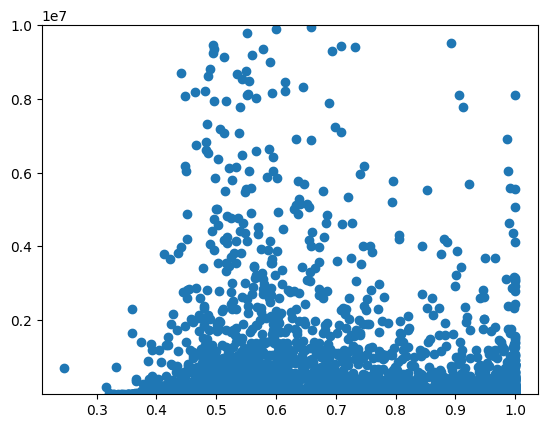

In [142]:
fig,ax = plt.subplots(1,1)
ax.scatter(max_chan,vol)
ax.set_ylim(10,10000000)
#ax.set_yscale('log')